## Этап 1. Подготовка

In [ ]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import (
    plot_acf,
    plot_pacf
)

from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    Lasso,
    ElasticNet
)
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    TimeSeriesSplit,
    train_test_split
)
from sklearn.pipeline import Pipeline

# отключим предупреждения
import warnings
warnings.filterwarnings("ignore")

# зафиксируем значение random state
RS = 12345

In [ ]:
# загрузим данные из локальной папки
# сохраним даты в индексы
df = pd.read_csv(
    'taxi.csv',
    index_col=[0],
    parse_dates=[0]
    )

# напишем функцию для проверки датасета
def check(df):
    display(
            # проверим общую информацию о датасете
            df.info(),
            df.head(),
            df.describe()
    )
    # проверим монотонность временного ряда
    print('Временная последовательность соблюдена:', df.index.is_monotonic)

    # проверим временной ряд на повторы
    print('Повторов нет:', df.index.is_unique)

In [ ]:
# проверим датасет
check(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Временная последовательность соблюдена: True
Повторов нет: True


- Данные представлены за период с 01.03.2018 по 31.08.2018
- В датасете нет пропусков
- У данных корректный тип и адекватные значения
- Данные распределены в интервалах по 10 минут
- Временной ряд монотонный, без повторов

In [ ]:
# выполним ресеплинг по одному часу, суммируем значения в пределах часа
df = df.resample('1H').sum()

# проверим результат
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод:**

Мы проверили датасет - данные качественные и корректные. Также мы успешно выполнили ресемплинг временного ряда по одному часу.

## Этап 2. Анализ

### Этап 2.1. Анализ количества заказов

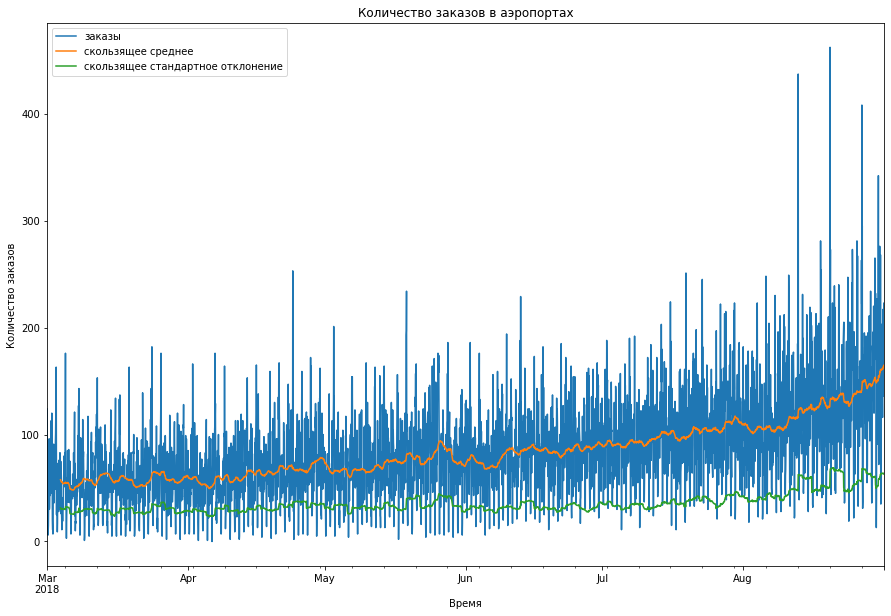

In [ ]:
# напишем функцию для расчета скользящего среднего и скользящего стандартного отклонения с построением графика
def show_roll_data(df, window_size):
    mean = df['num_orders'].rolling(window_size).mean()
    std = df['num_orders'].rolling(window_size).std()

    df.plot(figsize=(15, 10), grid=True)
    mean.plot()
    std.plot()
    plt.title('Количество заказов в аэропортах')
    plt.xlabel('Время')
    plt.ylabel('Количество заказов')
    plt.legend([
        'заказы',
        'скользящее среднее',
        'скользящее стандартное отклонение'
    ])
    plt.show()

# построим график со скользящими значеними
# установим размер окна в 72 часа
show_roll_data(df, 72)

С течением времени среднее количество заказов растет. Среднее отклонение тоже увеличивается: эта тенденция особенно заметна в августе. Следовательно, временной ряд нестационарен. Также на графике хорошо видны всплески количества заказов - в августе они значительны, рассмотрим всплески ближе:

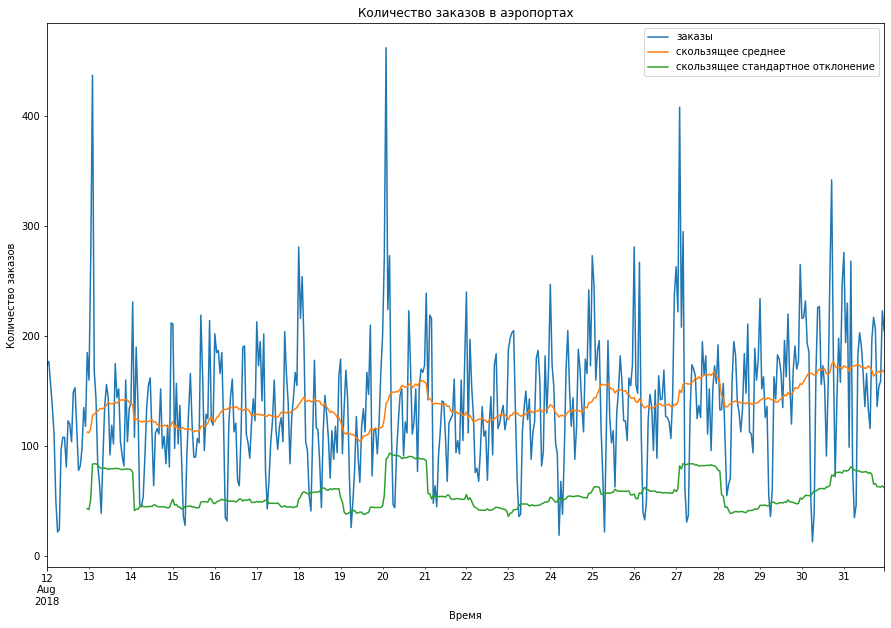

In [ ]:
# ограничим период на графике второй половиной августа
# сузим размер окна до 24 часов
show_roll_data(df['2018-08-12':'2018-08-31'], 24)

Количество заказов во второй половине августа резко растет по понедельникам: 13, 20, 27 августа. Также есть всплеск 30 августа. Увеличим масштаб графика: рассмотрим один из всплесков в разрезе суток:

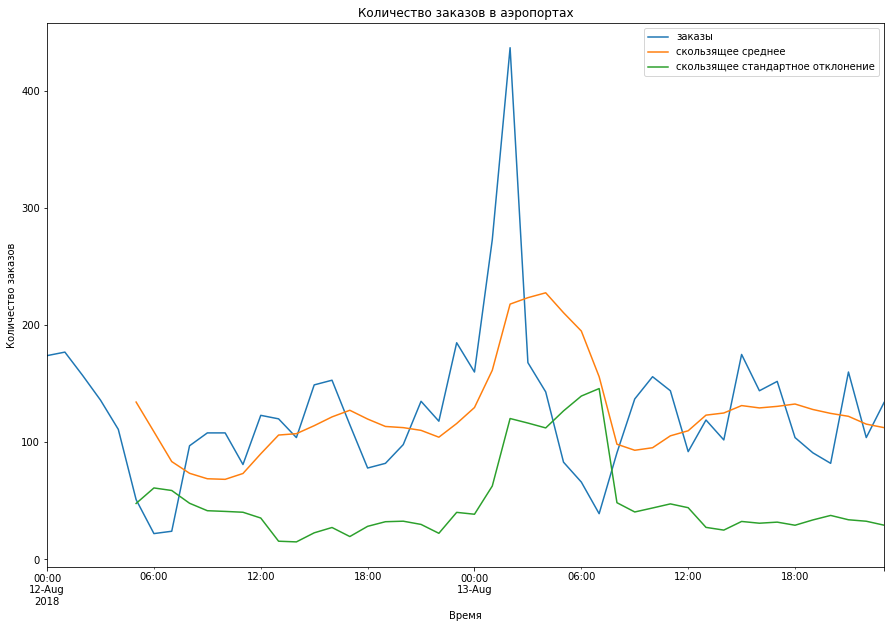

In [ ]:
# ограничим период на графике 12-13 августа
# сузим размер окна до 6 часов
show_roll_data(df['2018-08-12':'2018-08-13'], 6)

Количество заказов резко растет вскоре после полуночи, превышая число 400. В этот момент вместе с аномальным ростом резко увеличивается среднее значение и отклонение. После пика наступает стремительный провал в заказах, который достигает минимума около 6 утра.

Далее проанализируем тренд и сезонность.

### Этап 2.2. Анализ тренда и сезонности

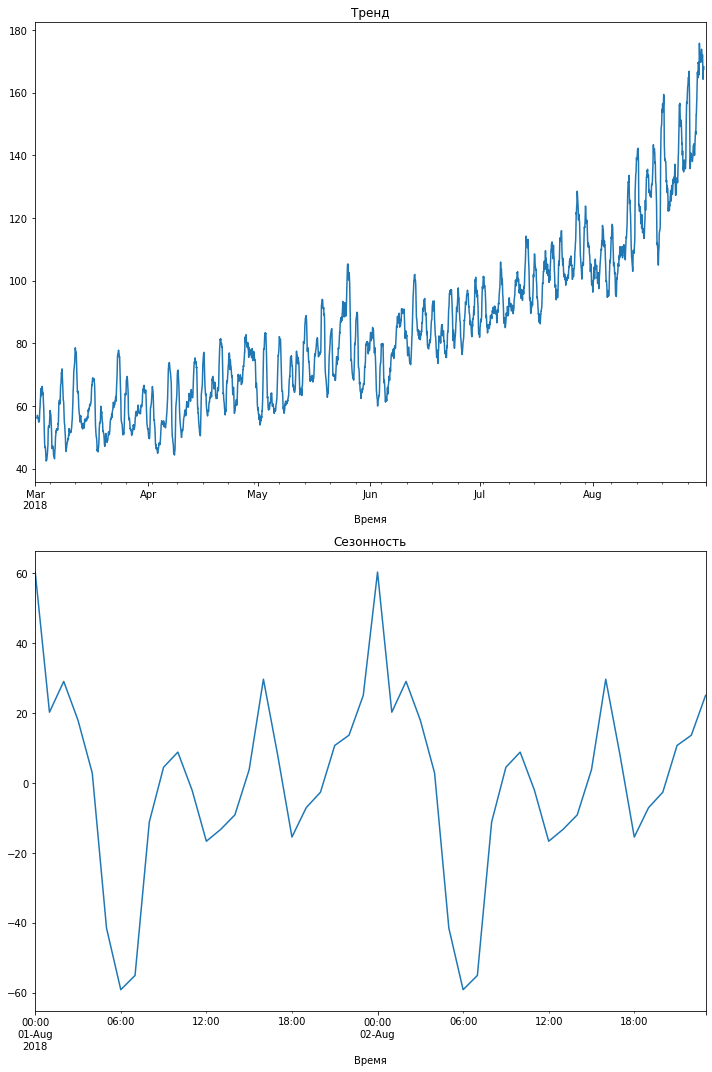

In [ ]:
# напишем функцию для вывода тренда и сезонности
def show_trend_seasonality(df, start, end):

    # разделим временной ряд на тренд, сезонность и остаток
    decomposed = seasonal_decompose(df)

    plt.figure(figsize=(10, 15))
    plt.subplot(211)

    # через ax=plt.gca() получим текущие оси для корректного отображения
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Тренд')
    plt.xlabel('Время')

    plt.subplot(212)
    decomposed.seasonal[start:end].plot(ax=plt.gca())
    plt.title('Сезонность')
    plt.xlabel('Время')
    plt.tight_layout()

# выведем график сезонности за два дня августа, а также график тренда
show_trend_seasonality(df, '2018-08-01', '2018-08-02')

Во временном ряду прослеживается тренд на увеличение количества заказов, начиная с апреля. Особенно резко количество заказов растет в августе.

На графике хорошо видна суточная сезонность:
1. Пик заказов приходится на время около полуночи
2. Далее следует резкий провал: количество заказов достигает минимума около 6 утра.
3. Ближе к началу рабочего дня количество заказов вновь резко растет.
4. Днем количество заказов меняется незначительно, заметно вырастая только после 18:00 и вновь достигая пика около полуночи.

### Этап 2.3. Анализ автокорреляции

Для нахождения оптимальных значений лага временного ряда и размера окна скользящего среднего, проанализируем графики автокорреляции. Мы выявили суточную сезонность в данных, а также в августе заметили еженедельные всплески и всплеск раз в три дня в конце месяца, поэтому возьмем количество лагов за сутки, неделю и для частичной автокорреляции за двое суток:

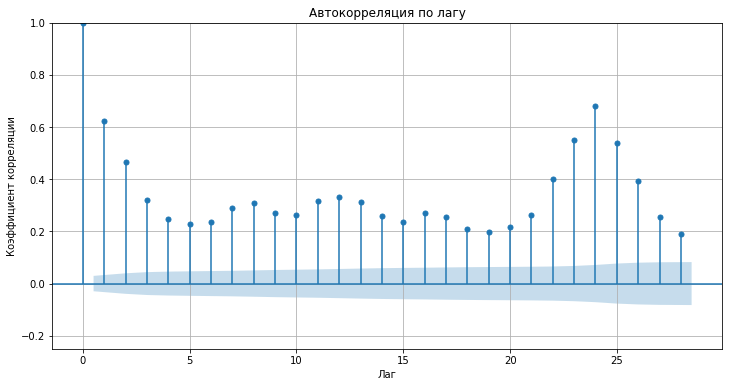

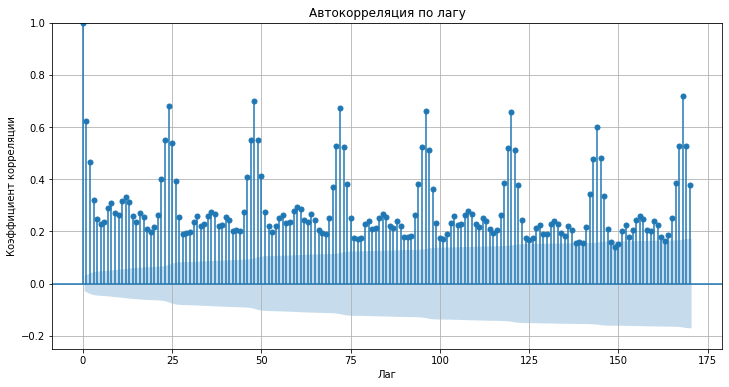

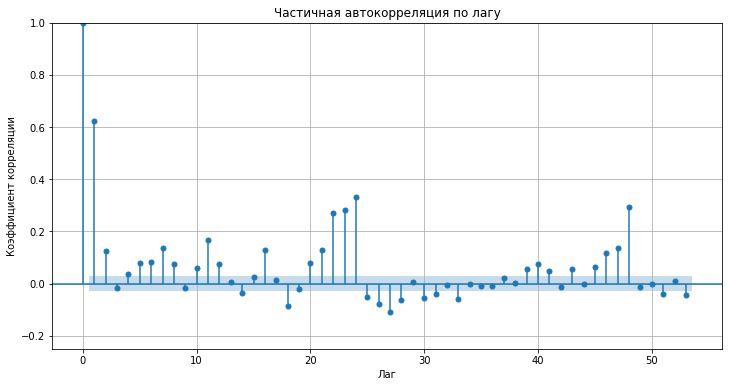

In [ ]:
# построим график автокорреляции временного ряда по лагу
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df, ax=ax, lags=28)
plt.title('Автокорреляция по лагу')
plt.xlabel('Лаг')
plt.ylabel('Коэффициент корреляции')
plt.ylim(-0.25, 1)
plt.grid()
plt.show()

# построим график автокорреляции временного ряда по лагу
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(df, ax=ax, lags=170)
plt.title('Автокорреляция по лагу')
plt.xlabel('Лаг')
plt.ylabel('Коэффициент корреляции')
plt.ylim(-0.25, 1)
plt.grid()
plt.show()

# построим график частичной автокорреляции временного ряда по лагу
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df, ax=ax, lags=53)
plt.title('Частичная автокорреляция по лагу')
plt.xlabel('Лаг')
plt.ylabel('Коэффициент корреляции')
plt.ylim(-0.25, 1)
plt.grid()
plt.show()

График показал максимальную корреляцию на лагах 1, 2, 3, 12, 22, 23, 25, 26, 48, 72, 168 часов. Это поможет нам спрогнозировать суточные, 3-дневные и недельные всплески, которые мы выявили в ходе анализа.

Судя по графику, оптимальным размером окна скользящего среднего будет 3 - именно три значения временного ряда хорошо покажут направление тренда, которое пригодится модели для предсказания.

**Вывод:**

- Количество заказов растет от месяца к месяцу, начиная с апреля. В августе рост ускорился.
- Среднее отклонение растет со временем. Временной ряд нестационарен.
- В данных прослеживается суточная сезонность: пик заказов около полуночи, минимум около 6 утра.
- В августе проявляется новая закономерность: еженедельные всплески по понедельникам, а также всплеск с периодичностью 3 дня в конце месяца.
- У временного ряда максимальная корреляция на лагах 1, 2, 3, 12, 22, 23, 25, 26, 48, 72, 168.
- Направление тренда оптимально подскажет окно скользящего среднего раземером 3.

## Этап 3. Подготовка моделей

### Этап 3.1. Создание признаков

In [ ]:
# напишем функцию для создания признаков
def make_features(data, lags, rolling_mean_size):

    # создадим копию датасета
    df = data.copy()

    # создадим календарные признаки
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    # создадим признаки с предыдущими значениями ряда
    for lag in lags:
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    # создадим признак со скользящим средним
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

    # удалим образовавшиеся пропуски
    df.dropna(inplace=True)

    return df

Возьмем для создания признаков оптимальные лаги, которые мы обнаружили в ходе анализа. Используем окно скользящего среднего размером 3, выявленное ранее:

In [ ]:
# создадим признаки
data = make_features(df, [1, 2, 3, 12, 22, 23, 24, 25, 26, 48, 72, 168], 3)

# проверим результат
check(data)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4248 entries, 2018-03-08 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4248 non-null   int64  
 1   month         4248 non-null   int64  
 2   day           4248 non-null   int64  
 3   dayofweek     4248 non-null   int64  
 4   lag_1         4248 non-null   float64
 5   lag_2         4248 non-null   float64
 6   lag_3         4248 non-null   float64
 7   lag_12        4248 non-null   float64
 8   lag_22        4248 non-null   float64
 9   lag_23        4248 non-null   float64
 10  lag_24        4248 non-null   float64
 11  lag_25        4248 non-null   float64
 12  lag_26        4248 non-null   float64
 13  lag_48        4248 non-null   float64
 14  lag_72        4248 non-null   float64
 15  lag_168       4248 non-null   float64
 16  rolling_mean  4248 non-null   float64
dtypes: float64(13), int64(4)
me

None

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_12,lag_22,lag_23,lag_24,lag_25,lag_26,lag_48,lag_72,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,3,8,3,94.0,127.0,108.0,34.0,24.0,121.0,100.0,47.0,81.0,42.0,86.0,124.0,109.666667
2018-03-08 01:00:00,78,3,8,3,143.0,94.0,127.0,55.0,66.0,24.0,121.0,100.0,47.0,75.0,176.0,85.0,121.333333
2018-03-08 02:00:00,65,3,8,3,78.0,143.0,94.0,43.0,73.0,66.0,24.0,121.0,100.0,36.0,32.0,71.0,105.000000
2018-03-08 03:00:00,68,3,8,3,65.0,78.0,143.0,51.0,10.0,73.0,66.0,24.0,121.0,49.0,51.0,66.0,95.333333
2018-03-08 04:00:00,60,3,8,3,68.0,65.0,78.0,46.0,19.0,10.0,73.0,66.0,24.0,30.0,34.0,43.0,70.333333


,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_12,lag_22,lag_23,lag_24,lag_25,lag_26,lag_48,lag_72,lag_168,rolling_mean
count,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000,4248.000000
mean,85.616996,5.604520,16.305085,3.005650,85.590866,85.568267,85.556262,85.330273,85.068974,85.051789,85.010358,84.963512,84.945386,84.308616,83.719397,81.658427,85.571798
std,45.115366,1.671348,8.694656,1.990315,45.078335,45.033473,45.020688,44.881939,44.687315,44.659443,44.563793,44.499068,44.484990,43.860736,43.481657,41.846399,37.957837
min,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.333333
25%,55.750000,4.000000,9.000000,1.000000,55.750000,55.750000,55.750000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,54.000000,53.000000,60.666667
50%,80.000000,6.000000,16.000000,3.000000,80.000000,80.000000,80.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,79.000000,78.000000,77.000000,80.333333
75%,109.000000,7.000000,24.000000,5.000000,109.000000,109.000000,109.000000,108.000000,108.000000,108.000000,108.000000,108.000000,108.000000,107.000000,107.000000,104.000000,105.333333
max,462.000000,8.000000,31.000000,6.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,462.000000,319.666667


Временная последовательность соблюдена: True
Повторов нет: True


Все признаки корректны. Далее подготовим выборки и обучим модели:

### Этап 3.2. Обучение моделей

In [ ]:
# разделим датасет на выборки
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('num_orders', axis=1),
    data['num_orders'],
    shuffle=False,
    test_size=.1
)

# проверим размер и размерность выборок
display(
    X_train.shape,
    X_test.shape,
    y_train.shape,
    y_test.shape
)

(3823, 16)

(425, 16)

(3823,)

(425,)

Используем пайплайн для подбора оптимальной модели с кросс-валидацией. Применим GridSearchCV с TimeSeriesSplit:

In [ ]:
# зададим шаги пайплайна
steps = [('regressor', LinearRegression(n_jobs=-1))]

# зададим модели с гиперпараметрами
params = [
    {'regressor': [LinearRegression()]
    },
    {'regressor': [Ridge(random_state=RS)],
     'regressor__alpha': [1, 5, 10] # default 1.0
    },
    {'regressor': [Lasso(random_state=RS)],
     'regressor__alpha': [1, 5, 10] # default 1.0
    },
    {'regressor': [ElasticNet(random_state=RS)],
     'regressor__alpha': [1, 5, 10], # default 1.0
     'regressor__l1_ratio': [.0, 0.25, 0.5, 0.75, 1.0] # default 0.5
    }
]

# напишем функцию для поиска оптимальных гиперпараметров
def pipeline_gridsearchcv(X, y, steps, params, verbose):

    # сформируем итоговый pipeline
    pipe = Pipeline(steps)

    # используем кросс-валидацию для временных рядов
    cv = TimeSeriesSplit()

    # собираем все вместе, используем RMSE в качестве метрики
    grid = GridSearchCV(
        pipe,
        param_grid=params,
        cv=cv,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error',
        verbose=verbose,
        error_score='raise'
    )
    grid.fit(X, y)

    # посмотрим лучшие гиперпараметры
    print('')
    print('Параметры лучшей модели:', grid.best_params_)
    print('Значение лучшей метрики качества: {:.2f}'.format(-grid.best_score_))

    return grid

In [ ]:
%%time

# определим лучшую модель
best_model = pipeline_gridsearchcv(X_train, y_train, steps, params, 1)

Fitting 5 folds for each of 22 candidates, totalling 110 fits

Параметры лучшей модели: {'regressor': Lasso(alpha=10, random_state=12345), 'regressor__alpha': 10}
Значение лучшей метрики качества: 22.21
CPU times: user 10.8 s, sys: 16.9 s, total: 27.7 s
Wall time: 27.7 s


Лучшей оказалась Lasso с гиперпараметром alpha=10.

**Вывод:**

- Мы успешно создали признаки, использовав оптимальные лаги и размер окна скользящего среднего, выявленные в ходе анализа.
- Мы исключили лаг в 24 часа чтобы избежать утечки целевого признака.
- Через подбор гиперпараметров с кросс-валидацией мы определили оптимальную модель среди нескольких: Lasso с гиперпараметром alpha=10.

## Этап 4. Тестирование

Для проверки нашей лучшей модели на адекватность, сверим ее RMSE с метрикой dummy-модели:

In [ ]:
# создадим dummy-модель
model_dummy = DummyRegressor()

# обучим dummy-модель и получим среднее значение
model_dummy.fit(X_train, y_train)
dummy_prediction = model_dummy.predict(X_test)

# найдем RMSE dummy-модели
dummy_score = mean_squared_error(y_test, dummy_prediction, squared=False)

# проверим результат
dummy_score

84.45113423436631

In [ ]:
# сделаем предсказания на тестовой выборке
prediction = best_model.predict(X_test)

# найдем RMSE на тестовой выборке
mean_squared_error(y_test, prediction, squared=False)

34.74002624620338

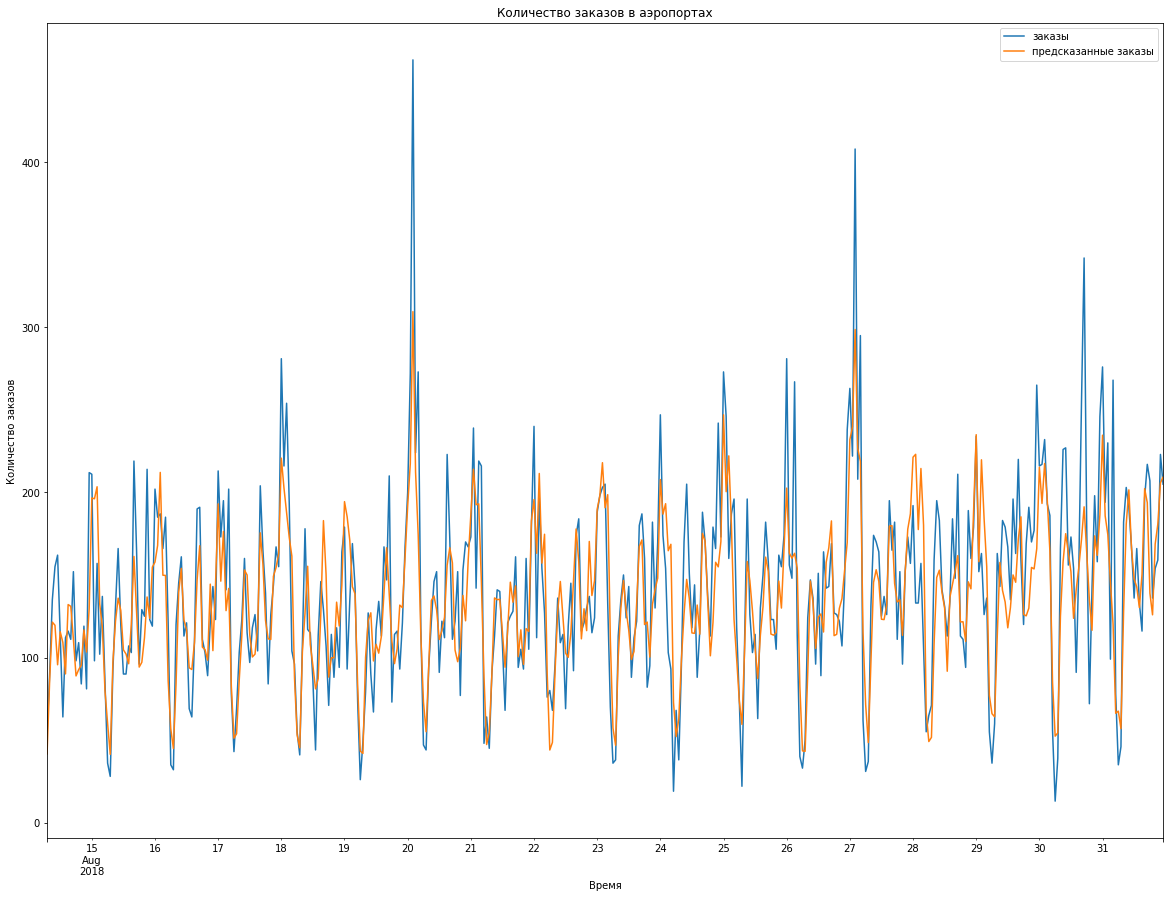

In [ ]:
# выведем на графике целевой признак и предсказания
y_test.plot(figsize=(20, 15), grid=True)
pd.Series(prediction, index=y_test.index).plot()
plt.title('Количество заказов в аэропортах')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.legend([
        'заказы',
        'предсказанные заказы'
    ])
plt.show()

**Вывод:**

Наша модель показала свою адекватность по сравнению с dummy-моделью, показав отличный результат по RMSE. Нам также удалось пройти порог RMSE = 48 по условиям задачи.

## Этап 5. Вывод

- Данные представлены за период с 01.03.2018 по 31.08.2018
- Нет пропусков, у данных корректный тип и адекватные значения
- Изначально данные были распределены в интервалах по 10 минут. Мы успешно выполнили ресемплинг временного ряда по одному часу.
- Временной ряд монотонный, без повторов
- Количество заказов растет от месяца к месяцу, начиная с апреля. В августе рост ускорился.
- Среднее отклонение растет со временем. Временной ряд нестационарен.
- В данных прослеживается суточная сезонность: пик заказов около полуночи, минимум около 6 утра.
- В августе проявляется новая закономерность: еженедельные всплески по понедельникам, а также всплеск с периодичностью 3 дня в конце месяца.
- У временного ряда максимальная корреляция на лагах 1, 2, 3, 12, 22, 23, 24, 25, 26, 48, 72, 168.
- Направление тренда оптимально подскажет окно скользящего среднего размером 3.

Используя информацию, полученную в ходе подготовки и анализа данных, мы:

- Успешно создали признаки, использовав оптимальные лаги и размер окна скользящего среднего, выявленные в ходе анализа.
- Через подбор гиперпараметров с кросс-валидацией определили оптимальную модель среди нескольких: Lasso с гиперпараметром alpha=10.
- Выбранная модель показала свою адекватность по сравнению с dummy-моделью, показав отличный результат по RMSE. Нам также удалось пройти порог RMSE = 48 по условиям задачи.